In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
train_og = pd.read_csv('data/train.csv')

test = pd.read_csv('data/test.csv')

In [3]:
train, validation = train_test_split(train_og,train_size=0.8,random_state=42)

y_train = train.iloc[:,0]
X_train = train.drop(train.columns[0],axis=1)

y_validation = validation.iloc[:,0]
X_validation = validation.drop(validation.columns[0],axis=1)

y_test = test.iloc[:,0]
X_test = test.drop(test.columns[0],axis=1)

In [4]:
import torch
import torch.nn as nn
import torchvision.ops as ops
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [5]:
def create_data(X_train, y_train, X_validation, y_validation, X_test, y_test):
    X_train_tensors = torch.tensor(X_train.values,dtype=torch.float32)
    y_train_tensors = torch.tensor(y_train.values,dtype=torch.long)

    dataset_train = TensorDataset(X_train_tensors,y_train_tensors)
    train_loader = DataLoader(dataset_train,batch_size=64,shuffle=True)

    X_validation_tensors = torch.tensor(X_validation.values,dtype=torch.float32)
    y_validation_tensors = torch.tensor(y_validation.values,dtype=torch.long)

    X_test_tensors = torch.tensor(X_test.values,dtype=torch.float32)
    y_test_tensors = torch.tensor(y_test.values,dtype=torch.long)

    return train_loader, X_validation_tensors, y_validation_tensors, X_test_tensors, y_test_tensors

In [6]:
train_loader, X_validation_tensors, y_validation_tensors, X_test_tensors, y_test_tensors = create_data(X_train, y_train, X_validation, y_validation, X_test, y_test)

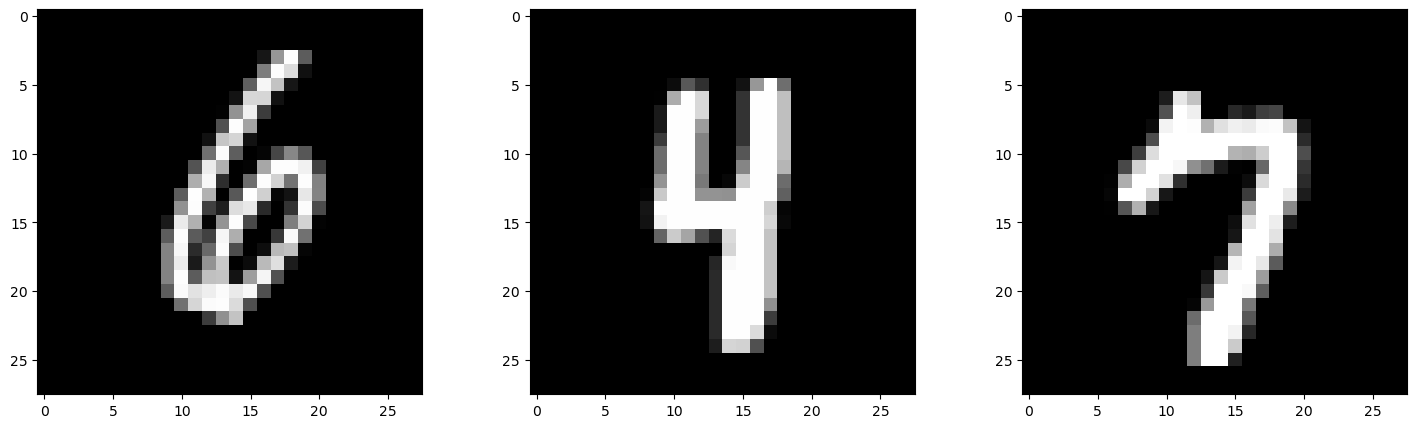

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X_train.iloc[i].values.reshape(28,28), cmap='gray')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [8]:
#!pip install torch

In [9]:
import torch 
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [10]:
output_size = 10
input_size = X_train.columns[0:].shape[0]

In [11]:
model = nn.Sequential(
    nn.Linear(input_size,28), # hidden layer
    nn.ReLU(), # activation
    nn.Linear(28,32), # hidden layer
    nn.ReLU(), # activation
    nn.Linear(32,output_size), # ouput
)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(),lr=0.001) # optimizer

In [12]:
def train_nn(model,loader):
    num_epochs = 100

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Variables to accumulate predictions and true labels
        all_preds = []
        all_labels = []

        for X_batch, y_batch in loader:
            # Forward pass: compute the output of the model
            outputs = model(X_batch)
            
            # Compute the loss
            loss = criterion(outputs, y_batch)

            # Backward pass: compute gradients
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Backpropagation

            # Update the weights
            optimizer.step()

            # Convert model outputs to predicted class indices
            _, predicted = torch.max(outputs, 1)

            # Accumulate predictions and true labels
            all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and store
            all_labels.extend(y_batch.cpu().numpy())   # Convert to numpy and store

        # Compute metrics at the end of the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')  # For multi-class problems
        recall = recall_score(all_labels,all_preds, average='weighted')
        precision = precision_score(all_labels,all_preds,average='weighted')

        # Print loss, accuracy, and F1 score every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Loss: {loss.item():.4f},')
        
    print(f'Training Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Recall: {recall}')
    #return loss.item(), accuracy, f1, recall

In [13]:
train_nn(model,train_loader) # train experiment 1

Epoch [10/100], Accuracy: 0.9500, Precision: 0.9500, Recall: 0.9500, F1 Score: 0.9500, Loss: 0.2557,
Epoch [20/100], Accuracy: 0.9585, Precision: 0.9585, Recall: 0.9585, F1 Score: 0.9585, Loss: 0.1065,
Epoch [30/100], Accuracy: 0.9616, Precision: 0.9616, Recall: 0.9616, F1 Score: 0.9616, Loss: 0.1991,
Epoch [40/100], Accuracy: 0.9652, Precision: 0.9653, Recall: 0.9652, F1 Score: 0.9652, Loss: 0.0857,
Epoch [50/100], Accuracy: 0.9665, Precision: 0.9665, Recall: 0.9665, F1 Score: 0.9665, Loss: 0.1382,
Epoch [60/100], Accuracy: 0.9691, Precision: 0.9692, Recall: 0.9691, F1 Score: 0.9691, Loss: 0.0663,
Epoch [70/100], Accuracy: 0.9679, Precision: 0.9679, Recall: 0.9679, F1 Score: 0.9678, Loss: 0.0806,
Epoch [80/100], Accuracy: 0.9708, Precision: 0.9709, Recall: 0.9708, F1 Score: 0.9708, Loss: 0.0807,
Epoch [90/100], Accuracy: 0.9699, Precision: 0.9699, Recall: 0.9699, F1 Score: 0.9699, Loss: 0.1942,
Epoch [100/100], Accuracy: 0.9703, Precision: 0.9703, Recall: 0.9703, F1 Score: 0.9703, Los

In [33]:
def evaluation_nn(model, X_set, y_set):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No need to calculate gradients for validation/testing
        outputs = model(X_set)
        val_loss = criterion(outputs, y_set)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())  # Convert to numpy and store
        all_labels.extend(y_set.cpu().numpy())   # Convert to numpy and store
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')  # For multi-class problems
        recall = recall_score(all_labels,all_preds, average='weighted')
        precision = precision_score(all_labels,all_preds, average='weighted')
        
        print(f'Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f},  Recall: {recall:.4f}, F1 Score: {f1:.4f}')


In [34]:
evaluation_nn(model,X_validation_tensors, y_validation_tensors) # evaluation on validation set experiment 1

Loss: 0.3906, Accuracy: 0.9334, Precision: 0.9339,  Recall: 0.9334, F1 Score: 0.9333


In [35]:
evaluation_nn(model,X_test_tensors, y_test_tensors) # evaluation of test set experiment 1

Loss: 0.3780, Accuracy: 0.9407, Precision: 0.9410,  Recall: 0.9407, F1 Score: 0.9406


In [17]:
model_2 = nn.Sequential(
    nn.Linear(input_size,28), # input
    nn.ReLU(), # activation
    nn.Linear(28,32), # hidden layer
    nn.ReLU(), # activation
    nn.Linear(32,20),
    nn.ReLU(), # activation
    nn.Linear(20,output_size), # ouput
)

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model_2.parameters(),lr=0.001) # optimizer

In [18]:
train_nn(model_2,train_loader) # train on experiment 2

Epoch [10/100], Accuracy: 0.9692, Precision: 0.9693, Recall: 0.9692, F1 Score: 0.9692, Loss: 0.1469,
Epoch [20/100], Accuracy: 0.9781, Precision: 0.9781, Recall: 0.9781, F1 Score: 0.9781, Loss: 0.0315,
Epoch [30/100], Accuracy: 0.9821, Precision: 0.9821, Recall: 0.9821, F1 Score: 0.9821, Loss: 0.0775,
Epoch [40/100], Accuracy: 0.9848, Precision: 0.9848, Recall: 0.9848, F1 Score: 0.9848, Loss: 0.0035,
Epoch [50/100], Accuracy: 0.9862, Precision: 0.9862, Recall: 0.9862, F1 Score: 0.9862, Loss: 0.0051,
Epoch [60/100], Accuracy: 0.9870, Precision: 0.9870, Recall: 0.9870, F1 Score: 0.9870, Loss: 0.0401,
Epoch [70/100], Accuracy: 0.9885, Precision: 0.9885, Recall: 0.9885, F1 Score: 0.9885, Loss: 0.0374,
Epoch [80/100], Accuracy: 0.9900, Precision: 0.9900, Recall: 0.9900, F1 Score: 0.9900, Loss: 0.0098,
Epoch [90/100], Accuracy: 0.9901, Precision: 0.9901, Recall: 0.9901, F1 Score: 0.9901, Loss: 0.0293,
Epoch [100/100], Accuracy: 0.9908, Precision: 0.9908, Recall: 0.9908, F1 Score: 0.9908, Los

In [19]:
evaluation_nn(model_2,X_validation_tensors,y_validation_tensors) # validation experiment 2

Loss: 0.3939, Accuracy: 0.9541, F1 Score: 0.9541, Recall: 0.9541


In [20]:
evaluation_nn(model_2,X_test_tensors,y_test_tensors) # validation experiment 2

Loss: 0.3450, Accuracy: 0.9615, F1 Score: 0.9615, Recall: 0.9615


In [21]:
model_3 = nn.Sequential(
    nn.Linear(input_size,28), # input
    nn.ReLU(), # activation
    nn.Linear(28,32), # hidden layer
    nn.Sigmoid(), # activation
    nn.Linear(32,20),
    nn.ReLU(), # activation
    nn.Linear(20,output_size), # ouput
)

In [22]:
train_nn(model_3,train_loader) # train on experiment 2

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [10/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3044,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [20/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.2844,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [30/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3428,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [40/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.2860,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [50/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3129,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [60/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3309,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [70/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3020,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [80/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3183,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [90/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3398,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [100/100], Accuracy: 0.1025, Precision: 0.0321, Recall: 0.1025, F1 Score: 0.0325, Loss: 2.3102,
Training Loss: 2.3102, Accuracy: 0.1025, F1: 0.0325, Recall: 0.10254380299589574


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
model_4 = nn.Sequential(
    nn.Linear(input_size,28), # input
    nn.ReLU(), # activation
    nn.Linear(28,32), # hidden layer
    nn.Tanh(), # activation
    nn.Linear(32,20),
    nn.ReLU(), # activation
    nn.Linear(20,output_size), # ouput
)

In [24]:
train_nn(model_4,train_loader) # train on experiment 2

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [10/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3724,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [20/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3466,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [30/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3301,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [40/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3628,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [50/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3626,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [60/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3313,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [70/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3438,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [80/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3373,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [90/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3858,


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homeb

Epoch [100/100], Accuracy: 0.1014, Precision: 0.0617, Recall: 0.1014, F1 Score: 0.0262, Loss: 2.3616,
Training Loss: 2.3616, Accuracy: 0.1014, F1: 0.0262, Recall: 0.1013979457905373


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [26]:
print(X_test.shape)
print(X_train.shape)
print(X_validation.shape)

import numpy as np

print(((np.isnan(X_test).sum() > 0) == True).sum())  # Check for NaNs
print(((np.isinf(X_test).sum() > 0) == True).sum())  # Check for Infinity values

X_train = X_train.astype(np.float64)
X_validation = X_validation.astype(np.float64)
X_test = X_test.astype(np.float64)

(9999, 784)
(47999, 784)
(12000, 784)
0
0


In [27]:
!pip install numpy

In [28]:
print(X_test.dtypes)  # Check the data types of each column

0        float64
0.1      float64
0.2      float64
0.3      float64
0.4      float64
          ...   
0.663    float64
0.664    float64
0.665    float64
0.666    float64
0.667    float64
Length: 784, dtype: object


In [29]:
Min_Max = MinMaxScaler()
X_train_mm = pd.DataFrame(Min_Max.fit_transform(X_train))
X_validation_mm = pd.DataFrame(Min_Max.transform(X_validation))
X_test_mm = pd.DataFrame(Min_Max.transform(X_test))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 0.618
- 0.619
- 0.620
- 0.621
- 0.622
- ...
Feature names seen at fit time, yet now missing:
- 1.1
- 107
- 108
- 11
- 11.1
- ...


In [ ]:
train_loader_mm, X_validation_tensors_mm, y_validation_tensors_mm, X_test_tensors_mm, y_test_tensors_mm = create_data(X_train_mm, y_train, X_validation_mm, y_validation, X_test_mm, y_test)

In [ ]:
train_nn(model,train_loader)

Epoch [10/100], Loss: 2.6287, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [20/100], Loss: 2.5603, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [30/100], Loss: 2.5738, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [40/100], Loss: 2.7697, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [50/100], Loss: 2.3558, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [60/100], Loss: 2.6017, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [70/100], Loss: 2.2423, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [80/100], Loss: 3.0653, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [90/100], Loss: 2.7776, Accuracy: 0.1262, F1 Score: 0.0527
Epoch [100/100], Loss: 2.8709, Accuracy: 0.1262, F1 Score: 0.0527
Training Loss: 2.8709, Accuracy: 0.1262, F1: 0.0527, Recall: 0.12619532044760937


In [ ]:
evaluation_nn(model, X_validation_tensors_mm,y_validation_tensors_mm)

Loss: 2.6355, Accuracy: 0.1194, F1 Score: 0.0518, Recall: 0.1194


In [ ]:
evaluation_nn(model,X_test_tensors_mm,y_test_tensors_mm)

Loss: 2.6353, Accuracy: 0.1259, F1 Score: 0.0564, Recall: 0.1259


In [ ]:
standard = StandardScaler()
X_train_ss = pd.DataFrame(standard.fit_transform(X_train))
X_validation_ss = pd.DataFrame(standard.fit_transform(X_validation))
X_test_ss = pd.DataFrame(standard.fit_transform(X_test))

In [ ]:
train_loader_ss, X_validation_tensors_ss, y_validation_tensors_ss, X_test_tensors_ss, y_test_tensors_ss = create_data(X_train_ss, y_train, X_validation_ss, y_validation, X_test_ss, y_test)

In [ ]:
train_nn(model,train_loader_ss)

Epoch [10/100], Loss: 1.9187, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [20/100], Loss: 1.4353, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [30/100], Loss: 2.5542, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [40/100], Loss: 1.9252, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [50/100], Loss: 1.1325, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [60/100], Loss: 1.5064, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [70/100], Loss: 1.8451, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [80/100], Loss: 1.4807, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [90/100], Loss: 1.6844, Accuracy: 0.3510, F1 Score: 0.3180
Epoch [100/100], Loss: 1.9156, Accuracy: 0.3510, F1 Score: 0.3180
Training Loss: 1.9156, Accuracy: 0.3510, F1: 0.3180, Recall: 0.3510172939979654


In [ ]:
total_data = train.shape[0] + test.shape[0] + validation.shape[0]

test.shape[0]/total_data

# % * whole = part

0.1428469384839567

In [ ]:
# % * whole = part

validation.shape

(12000, 785)

In [ ]:
train.shape[0]/total_data

0.6857195919883425

In [ ]:
validation.shape[0]/total_data

0.1714334695277008

In [ ]:
train_og.shape

(59999, 785)